<a href="https://colab.research.google.com/github/jmcinern/NLP_QUB/blob/main/SentimentAnalysis_JosephMcInerney_40460549_section3code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# 3.0 Data Preprocessing



## 3.0a Load Stories Data from JSON

In [1]:
RANDOM_STATE = 40460549

In [2]:
# Mount g-drive
from google.colab import drive
drive.mount('/content/drive/')
import json, os
# Stories dataset in same dir as notebook.
pth = '/content/drive/MyDrive/NLP/Project/'
fn = 'stories.json'
with open(os.path.join(pth, fn), 'r') as ifh:
    data = json.load(ifh)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import spacy
# only using spacy for tokenization and stop word checking so can disable other features
# -that get processed
# sentencizer for 3.1 to get last sentence
nlp = spacy.load("en_core_web_sm", enable=['tok2vec'])
nlp.add_pipe('sentencizer')

In [4]:
from tqdm import tqdm

## 3.2b Get Design Matrix and Target Variables

In [5]:
stories_X = []
# 3.1 vicory/defeat
outcomes_y =[]
# 3.2 "Rebellion", "Discovery", "Betrayal", and "Redemption"
themes_y =[]

for story in tqdm(data['stories']):
  stories_X.append(nlp(story['story']))
  outcomes_y.append(story['outcome'])
  themes_y.append(story['theme'])



100%|██████████| 602/602 [00:09<00:00, 60.21it/s]


# 3.1 Sentiment analysis with BERT.  

TODO: The stories have been created to have two types of outcome – “victory” and “defeat”. This
information is provided in the “outcome” field of the story metadata. Using the last sentence
in each story only, fine-tune a pre-trained BERT model to predict the type of outcome. Evaluate
and interpret the results.

## 3.1a Get last senteces for X

In [6]:
# -1 index is last index. have  preprocessed using spaCY sentencizer.
X_last_sentence = [list(doc.sents)[-1] for doc in stories_X]
X_last_sentence_lengths = [len(sentence) for sentence in X_last_sentence]

In [7]:
# Make sure behaving as expected and getting last sentences
X_last_sentence[0:5]

[His final gambit, a symphony of silence permeated by the relentless hum of victorious mechanical locusts.,
 The illustrious career of our protagonist met a harsh setback, a clear reminder of the immense gambles involved when challenging the firmament's unforgiving wilderness.,
 The townsfolk slept, oblivious to the unfolding drama and the triumphant grin that Kerr wore as he slipped back into the moonlit night.,
 This once-simple farmer had transformed into their guardian, their hero.,
 His relentless pursuit of righting the wrong had drained him, yet the sense of having reclaimed his own humanity from the jaws of a greed-fuelled error, filled the cavernous depths of his erstwhile torment with a warm, radiant light.]

## 3.1b Fine-tune BERT to Classify Outcome from Last Sentence (X)

### Set up Data Loader

In [8]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [9]:
# pytorch deals with words and not numbers.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
outcomes_y_enc = label_encoder.fit_transform(outcomes_y)
print(f'{set(outcomes_y)} -> {set(outcomes_y_enc)}')

{'victory', 'defeat'} -> {0, 1}


Split Data into Train/Val/Test

In [10]:
# use same X and y train/test split to compare BERT to Word2vec
X_train_BERT, X_test_BERT, y_train_BERT, y_test_BERT = train_test_split(
    X_last_sentence, outcomes_y_enc, test_size=0.2, random_state=RANDOM_STATE
)

# Also get validation set from the train set. keep the test set untouched to allow for a fair
# comparison between classifiers.
X_temp_BERT, X_val_BERT, y_temp_BERT, y_val_BERT = train_test_split(
    X_train_BERT, y_train_BERT, test_size=0.2, random_state=RANDOM_STATE
)

In [11]:
# Specify middle size BERT model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
class StoryOutcomeDataset(Dataset):
  """A custom dataset class for handling the Story and their setting"""

  # The constructor method initializes the dataset object with data and configurations.
  def __init__(self, stories, targets, tokenizer, max_len):
    self.stories = stories  # List of review texts
    self.targets = targets  # Corresponding targets (labels) for each story: its setting
    self.tokenizer = tokenizer  # Tokenizer for encoding the reviews
    self.max_len = max_len  # Maximum length of the tokenized input sequences

  # This method returns the number of items (reviews) in the dataset.
  def __len__(self):
    return len(self.stories)

  # This method retrieves a single item from the dataset by its index (`item`).
  def __getitem__(self, item):
    story = str(self.stories[item])  # Ensure the review is a string
    target = self.targets[item]  # Get the corresponding target for the review

    # Tokenize the review text. The tokenizer converts the text into a format
    # that can be understood by the model, including:
    #    - Adding special tokens (e.g., [CLS], [SEP]) necessary for some models.
    #    - Truncating or padding the sequence to `max_len`.
    #    - Generating an attention mask to differentiate real tokens from padding.
    #    - Returning the result as PyTorch tensors (`'pt'`).
    encoding = self.tokenizer.encode_plus(
      story,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    # Return a dictionary containing the original review text, the encoded input IDs,
    # the attention mask, and the target label, ready for training or evaluation.
    return {
      'story_text': story,
      'input_ids': encoding['input_ids'].flatten(),  # Flatten the tensor for compatibility with model inputs
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)  # Convert the target to a PyTorch tensor
    }


In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  """A function to create a DataLoader for the given dataset"""

  # Create an instance of the GPReviewDataset class with the specified parameters.
  # - `df.content.to_numpy()`:    Converts the 'content' column of the DataFrame into a
  #                               NumPy array of review texts.
  # - `df.sentiment.to_numpy()`:  Converts the 'sentiment' column of the DataFrame into
  #                               a NumPy array of target labels.
  # - `tokenizer`:                The tokenizer to use for encoding the review texts.
  # - `max_len`:                  The maximum length of the tokenized sequences.
  ds = StoryOutcomeDataset(
    stories=df.last_sentence.to_numpy(),
    targets=df.outcome.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  # Return a DataLoader object that wraps the dataset `ds`.
  # - `batch_size=batch_size`:  Specifies how many samples per batch to load.
  # - `num_workers=4`:          Specifies how many subprocesses to use for data loading.
  #                             More workers can increase the parallelism and speed up
  #                             the data loading process, depending on the environment.
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [14]:
# convert BERT train/val/test to dataframes
df_train = pd.DataFrame({'last_sentence': X_train_BERT, 'outcome': y_train_BERT})
df_val = pd.DataFrame({'last_sentence': X_val_BERT, 'outcome': y_val_BERT})
df_test = pd.DataFrame({'last_sentence': X_test_BERT, 'outcome': y_test_BERT})

In [15]:
df_train.head()

,last_sentence,outcome
0,"(The, shared, sense, of, shock, left, the, sin...",0
1,"(Liberated, from, the, programmed, path, of, m...",1
2,"(Salvation, lost, ,, yet, perhaps, in, defeat,...",0
3,"(His, audacity, and, perseverance, burrowed, t...",1
4,"(Discord, was, replaced, with, harmony, ,, cha...",1


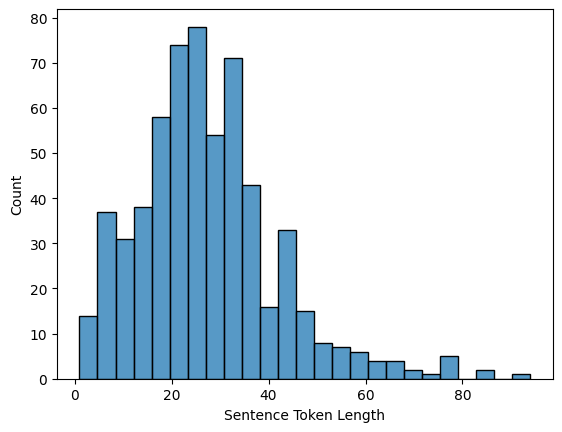

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize sentence length distribution for padding information
fig, ax = plt.subplots()
ax.set(xlabel='Sentence Token Length', ylabel='Count')
sns.histplot(X_last_sentence_lengths, ax=ax)
plt.show()

In [17]:
BATCH_SIZE = 16 #32
MAX_LEN = 50 # BERT max length

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Train

In [18]:
class LastSentenceOutcomeClassifier(nn.Module):

  def __init__(self, n_classes):
    super(LastSentenceOutcomeClassifier, self).__init__()
    # Model is simply BERT followed by a linear layer:
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    # Get the BERT pooled output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    # BERT output through linear layer:
    output = self.drop(pooled_output)
    return self.out(output)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set up training, hyperparameters etc. From Tutorial 9:

The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5:, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [20]:
model = LastSentenceOutcomeClassifier(len(set(outcomes_y)))
model = model.to(device)

#### Hyper-parameters

In [21]:
from transformers import get_cosine_schedule_with_warmup

EPOCHS = 2 #4: ~80% #2: 78.5%
optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)  # Start with a lower learning rate
total_steps = len(train_data_loader) * EPOCHS

# Cosine annealing with warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # Warmup for 10% of training steps
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
# Define a function for training the model for one epoch.
def train_epoch(
  model,           # The model to be trained
  data_loader,     # DataLoader that provides batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  optimizer,       # Optimization algorithm to adjust model parameters based on gradients
  device,          # Device (CPU/GPU) on which the computation will be performed
  scheduler,       # Learning rate scheduler to adjust the learning rate over epochs
  n_examples       # Total number of examples in the dataset
):
  # Set the model to training mode (enables dropout, batch normalization, etc.)
  model = model.train()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  # Iterate over each batch in the data loader
  for d in data_loader:
    # Move the batch data to the specified device
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    # Forward pass: compute the model outputs with input_ids and attention_mask
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    # Compute the predictions by finding the index of the max logit
    _, preds = torch.max(outputs, dim=1)
    # Calculate the loss between the model outputs and true targets
    loss = loss_fn(outputs, targets)

    # Count correct predictions to calculate accuracy
    correct_predictions += torch.sum(preds == targets)
    # Append the loss of the current batch to the list
    losses.append(loss.item())

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()

    #debugging: view gradients
    gradients = model.out.weight.grad
    #print(gradients)

    # Clip gradients to prevent the exploding gradient problem
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    # Perform a single optimization step (parameter update)
    optimizer.step()
    # Update the learning rate
    scheduler.step()
    # Clear the gradients of all optimized variables
    optimizer.zero_grad()

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
# Define a function for evaluating the model's performance on a dataset.
def eval_model(
  model,           # The model to be evaluated
  data_loader,     # DataLoader providing batches of the dataset
  loss_fn,         # Loss function to calculate the difference between expected and actual outcomes
  device,          # Device (CPU/GPU) on which the computation will be performed
  n_examples       # Total number of examples in the dataset
):
  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
  model = model.eval()

  losses = []  # List to store the loss of each batch
  correct_predictions = 0  # Counter for the number of correct predictions

  # Disable gradient computation to save memory and computation during evaluation
  with torch.no_grad():
    # Iterate over each batch in the data loader
    for d in data_loader:
      # Move the batch data to the specified device
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      # Forward pass: compute the model outputs with input_ids and attention_mask
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      # Compute the predictions by finding the index of the max logit
      _, preds = torch.max(outputs, dim=1)

      # Calculate the loss between the model outputs and true targets
      loss = loss_fn(outputs, targets)

      # Count correct predictions to calculate accuracy
      correct_predictions += torch.sum(preds == targets)
      # Append the loss of the current batch to the list
      losses.append(loss.item())

  # Calculate the average accuracy and loss over all examples
  return correct_predictions.double() / n_examples, np.mean(losses)


In [24]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_10.bin') # save best model
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.6930791245352838 accuracy 0.5467775467775469
Val   loss 0.6802427087511335 accuracy 0.5154639175257731

Epoch 2/2
----------
Train loss 0.647394323541272 accuracy 0.5966735966735968
Val   loss 0.4523024388722011 accuracy 0.845360824742268

CPU times: user 3.75 s, sys: 1.81 s, total: 5.56 s
Wall time: 6.31 s


### Test

In [25]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7768595041322315

# 3.2 Emotional content of stories

TODO: Using a pre-trained emotion detection model available on huggingface3 , get a probability
distribution for each sentence in each story. Average these probability vectors together to get
an emotion vector for each story. For each story, the metadata provides a “theme" field
associated with each story: "Rebellion", "Discovery", "Betrayal", and "Redemption".
Investigate whether and how the emotional content differs across the four “theme" categories